# **Preamble**

## Imports

In [3]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from datetime import datetime as dt
from collections import Counter, defaultdict
import subprocess
import re
import itertools
from seaborn import apionly as sns
import scipy as sp
from multiprocessing import Pool
import random
import pickle
import requests as rq
import json
from sklearn.metrics import normalized_mutual_info_score
import os

## Set layout params

In [4]:
plt.style.use(["classic"])
np.set_printoptions(precision=4)
np.core.arrayprint._line_width = 100

class cmap_in_range:
    """Create map to range of colors inside given domain.

    Example
    -------
    >>> cmap = cmap_in_range([0, 100])
    >>> cmap(10)
    (0.30392156862745101, 0.30315267411304353, 0.98816547208125938, 1.0)
    """
    def __init__(self, cmap_domain, cmap_range=[0, 1], cmap_style='rainbow'):
        self.cmap_domain = cmap_domain
        self.cmap_range = cmap_range
        self.m = interp1d(cmap_domain, cmap_range)
        self.cmap = plt.get_cmap(cmap_style)
        
    def __call__(self, value):
        if not self.cmap_domain[0] <= value <= self.cmap_domain[1]:
            raise Exception("Value must be inside cmap_domain.")
        return self.cmap(self.m(value))

def standarize_plot_parameters():
    # http://scipy.github.io/old-wiki/pages/Cookbook/Matplotlib/LaTeX_Examples
    # thesis has 417.47 points in column size, with 0.6\columnwidth
    golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
    fig_width = 3.42/2  # width in inches
    fig_height = 1.2       # height in inches
    params = {
        'axes.labelsize': 10,
        'legend.fontsize': 7,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'figure.figsize': [fig_width, fig_height],
        'font.family': 'STIXGeneral',  # close enough to LaTeX font
        'font.size': 8,
        'figure.frameon': False
    }
    plt.rcParams.update(params)

standarize_plot_parameters()

# **Utility functions**

## General

In [5]:
def default_to_regular(d):
    """Recursively convert nested defaultdicts to nested dicts.

    Source: http://stackoverflow.com/questions/26496831/how-to-convert-defaultdict-of-defaultdicts-of-defaultdicts-to-dict-of-dicts-o
    """
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.iteritems()}
    return d

def invert_partition(partition):
    if type(partition.items()[0][1]) is list:
        partition_inv = dict()
        for c, nodes in partition.items():
            for n in nodes:
                partition_inv[n] = c
    else:
        partition_inv = defaultdict(list)
        for n, c in partition.items():
            partition_inv[c].append(n)
    return default_to_regular(partition_inv)

def smooth(y, box_pts):
    """Sliding box smoothening of noisy data.

    Parameters
    ----------
    y : list
        Noisy y-variable. Must be sorted wrt. time.

    box_pts : int
        Convolution box size. The greater the box the smoother the plot.

    Output
    ------
    y_smooth : list
        Smooth points to replace y. Same dimensions as y.

    Example
    -------
    x = np.linspace(0,2*np.pi,100)
    y = np.sin(x) + np.random.random(100) * 0.8

    plt.plot(x, y,'o')
    plt.plot(x, smooth(y, 18), 'r-', lw=2)
    plt.plot(x, smooth(y,9), 'g-', lw=2)
    """
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plt_log_hist(v, **kwargs):
    """Make logplot of histogram."""
    # Handle input paramaters
    bins = kwargs.get('bins', 10)
    del kwargs['bins']
    
    # Construct log-bins
    if min(v) == 0:
        v = (np.array(v) + 0.01)
    logbins = np.logspace(np.log10(min(v)), np.log10(max(v)), bins)
    
    # Plot
    plt.hist(v, bins=logbins, **kwargs)
    plt.xscale("log")
    
def shannon_entropy(counts):
    """Compute shannon entropy of count series."""
    freq = np.array(counts) * 1.0 / np.sum(counts)
    return -np.sum([f * np.log2(f) for f in freq if f != 0])

def get_x_y_steps(x, y, where="post"):
    """Plot step function from x and y coordinates."""
    if where == "post":
        x_step = [x[0]] + [_x for tup in zip(x, x)[1:] for _x in tup]
        y_step = [_y for tup in zip(y, y)[:-1] for _y in tup] + [y[-1]]
    elif where == "pre":
        x_step = [_x for tup in zip(x, x)[:-1] for _x in tup] + [x[-1]]
        y_step = [y[0]] + [_y for tup in zip(y, y)[1:] for _y in tup]
    return x_step, y_step

def mean_confidence_interval(data, confidence=0.95):
    """Compute MCI for series (possibly multiple series)"""
    def _isarray(obj):
        try:
            list(obj)
            return True
        except TypeError:
            return False
        
    if _isarray(data[0]):
        out_vals = []
        for arr in data:
            a = 1.0*np.array(arr)
            h = sp.stats.sem(a) * sp.stats.t._ppf((1+confidence)/2., len(a)-1)
            out_vals.append(h)
    else:
        a = 1.0*np.array(data)
        h = sp.stats.sem(a) * sp.stats.t._ppf((1+confidence)/2., len(a)-1)
        out_vals = h

    return out_vals

def node_communities(layer_commu):
    """Return list of communities each node participates in."""
    communities = defaultdict(list)
    for l in sorted(layer_commu.keys()):
        for c, nodes in layer_commu[l].items():
            for n in nodes:
                communities[n].append(c)
    return communities

def community_nodes(layer_commu):
    communities = defaultdict(list)
    for partition in layer_commu.values():
        for c, nodes in partition.items():
            communities[c].extend(nodes)
    return communities

def shuffle_dict_kvs(partition):
    def _shuffle_list(l):
        l_out = list(l)[:]
        random.shuffle(l_out)
        return l_out
    return dict(zip(_shuffle_list(partition.keys()), _shuffle_list(partition.values())))

def ravel_two_level(arrarr):
    return [v for arr in arrarr for v in arr]

## Data

In [6]:
def load_binned_network(kind, filename):
    with open('data/processed_data/binned_networks/'+kind+'/'+filename+'.pkl', 'r') as infile:
        return pickle.load(infile)

## Visualization

In [7]:
class cmap_in_range:
    """Create map to range of colors inside given domain.

    Example
    -------
    >>> cmap = cmap_in_range([0, 100])
    >>> cmap(10)
    (0.30392156862745101, 0.30315267411304353, 0.98816547208125938, 1.0)
    """
    def __init__(self, cmap_domain, cmap_range=[0, 1], cmap_style='rainbow'):
        self.cmap_domain = cmap_domain
        self.cmap_range = cmap_range
        self.m = interp1d(cmap_domain, cmap_range)
        self.cmap = plt.get_cmap(cmap_style)
        
    def __call__(self, value):
        if not self.cmap_domain[0] <= value <= self.cmap_domain[1]:
            raise Exception("Value must be inside cmap_domain.")
        return self.cmap(self.m(value))
    
def draw(G, partition=False, colormap='rainbow'):
    """Draw graph G in my standard style.

    Input
    -----
    G : networkx graph
    partition : bool
    """

    def shuffle_list(l):
        l_out = list(l)[:]
        random.shuffle(l_out)
        return l_out
    
    def _get_cols(partition):
        return dict(
            zip(
                shuffle_list(set(partition.values())),
                np.linspace(0, 256, len(set(partition.values()))).astype(int)
            )
        )

    cmap = plt.get_cmap(colormap)
    if partition == True:
        partition = community.best_partition(G)
        cols = _get_cols(partition)
        colors = [cmap(cols[partition[n]]) for n in G.nodes()]
    elif type(partition) is dict and len(partition) == len(G.nodes()):
        cols = _get_cols(partition)
        colors = [cmap(cols[partition[n]]) for n in G.nodes()]
    elif type(partition) in [list, tuple] and len(partition) == len(G.nodes()):
        colors = list(partition)
    else:
        try:
            colors = [cmap(n[1]['node_color']) for n in G.nodes(data=True)]
        except KeyError:
            # nodes do not have node_color attribute
            colors = "grey"
    
    pos = nx.nx_pydot.graphviz_layout(G, prog='neato')
    nx.draw_networkx_edges(G, pos=pos, width=2, alpha=.3, zorder=-10)
    nx.draw_networkx_nodes(G, pos=pos, node_size=120, alpha=1, linewidths=0, node_color=colors)
    plt.axis("off")

## Networks

In [72]:
def Infomap(pajek_string, *args, **kwargs):
    """Function that pipes commands to subprocess and runs native Infomap implementation.
    
    Requires two folders (1) 'input' and (2) 'output', in sister-directory of 'infomap' folder
    that contains 'Infomap' executable. To setup 'infomap' folder, close Infomap from 
    https://github.com/mapequation/infomap and run 'make' inside resulting folder.
    
    Parameters
    ----------
    pajek_string : str
        Pajek representation of the network (str)
    *args : dict
        Infomap execution options. (http://www.mapequation.org/code.html#Options)
    Returns
    -------
    communities : list of lists
    layer_communities : data structure in required format for d3 viz (json)
    """
    
    def _get_id_to_label(filename):
        def __int_if_int(val):
            try: return int(val)
            except ValueError: return val
        with open('input/' + filename + ".net", 'r') as fp:
            parsed_network = fp.read()
        return dict(
            (int(n.split()[0]), __int_if_int(n.split('"')[1]))
            for n in re.split(r"\*.+", parsed_network)[1].split("\n")[1:-1]
        )
    
    def _parse_communities_multiplex(id_to_label, filename):
        with open('output/'+filename+"_expanded.clu", 'r') as infile:
            clusters = infile.read()

        # Get layers, nodes and clusters from _extended.clu file
        la_no_clu_flow = re.findall(r'\d+ \d+ \d+ \d\.\d+', clusters) # ["30 1 2 0.00800543",...]
        la_no_clu_flow = [tuple(i.split()) for i in la_no_clu_flow]

        node_flow_json = defaultdict(float)      # {layer_node: flow, ...}
        community_flow_json = defaultdict(float) # {community: flow, ...}
        communities_json = defaultdict(set)      # {layer: {(node, cluster), ...}, ...}
        for layer, node, cluster, flow in la_no_clu_flow:
            node_flow_json[(int(layer), id_to_label[int(node)])] += float(flow)
            community_flow_json[cluster] += float(flow)
            communities_json[int(layer)].add((id_to_label[int(node)], int(cluster)))

        return communities_json, node_flow_json, community_flow_json
    
    def _parse_communities_planar(id_to_label, filename):
        with open('output/'+filename+".clu", 'r') as infile:
            clusters = infile.read()
        
        # Get nodes and clusters from .clu file
        no_clu = [tuple(i.split()[:-1]) for i in re.findall(r"\d+ \d+ \d\.\d+", clusters)]  # [(node, cluster), ...]
        return {0: set([(id_to_label[int(no)], int(clu)) for no, clu in no_clu])}
    
    def _clean_up(filename):
        subprocess.call(['rm', 'input/'+filename+'.net'])
        subprocess.call(['rm', 'output/'+filename+'_expanded.clu'])
        subprocess.call(['rm', 'output/'+filename+'.clu'])
    
    # Check for process id in args (for multiprocessing)
    if args[-1][:3] == "pid":
        pid = args[-1][3:]
        args = args[:-1]
    else:
        pid = ""
        
    # Set default kwarg params
    return_flow = kwargs.get("return_flow", False)
        
    # Get network in multiplex string format and define filename
    filename = 'tmpnet' + pid

    # Store locally
    with open("input/"+filename+".net", 'w') as outfile:
        outfile.write(pajek_string)
    
    # Run Infomap for multiplex network
    subprocess.call(
        ['./infomap/Infomap', 'input/'+filename+".net"] + \
        list(args)
    )
    
    # Parse communities from Infomap output
    id_to_label = _get_id_to_label(filename)
    
    if 'multiplex' in list(args):
        parsed_communities, node_flow, community_flow = _parse_communities_multiplex(id_to_label, filename)
    if 'pajek' in list(args):
        parsed_communities = _parse_communities_planar(id_to_label, filename)
        
    _clean_up(filename)

    orig_clu = [item for sublist in parsed_communities.values() for item in sublist]
    communities = dict()
    for key, group in itertools.groupby(orig_clu, lambda x: x[1]):
        for thing in group:
            try:
                communities[key].append(thing[0])
            except KeyError:
                communities[thing[1]] = [thing[0]]
    communities = dict((k,set(v)) for k,v in communities.items())

    layer_communities = {}
    for layer, group in parsed_communities.items():
        communities = {}
        for no, clu in group:
            try:
                communities[clu-1].append(no)
            except KeyError:
                communities[clu-1] = [no]
        layer_communities[layer] = communities

    if return_flow:
        return communities, layer_communities, node_flow, community_flow
    else:
        return communities, layer_communities
    
    
def build_adjacency_tensor(layers, index="zero"):
    nodes = set([
        n
        for l in layers
        for n in list(l['user1']) + list(l['user2'])
    ])
    
    ind = dict((n, i) for i, n in enumerate(nodes))
    
    A = defaultdict(int)
    for l, layer in enumerate(layers):
        for _, row in layer.iterrows():
            # Must add both ways if undirected so A becomes symmetrical. If only added one-way
            # triu will only be connections from 'user' and and tril from 'bt_mac' or vice versa.
            if index == "zero":
                A[(ind[row['user1']], ind[row['user2']], l)] += 1
                A[(ind[row['user2']], ind[row['user1']], l)] += 1
            else:
                A[(row['user1'], row['user2'], l)] += 1
                A[(row['user2'], row['user1'], l)] += 1
    return A


def write_pajek(A, node_labels=None, index_from=0):
    """Return multiplex representation of multiplex network adjacency matrix A
    
    Providing an adjacency tensor where A[:, :, k] is adjacency matrix of temporal
    layer k, return a pajek format representation of the temporal network which weights interlayer
    edges by state node neighborhood similarity. 
    
    Parameters
    ----------
    A : numpy.3darray
        3d tensor where each A[:, :, k] is a layer adjacency matrix
    node_labels : list
        List of node labels if (optional)
    index_from : int
        From which number to index nodes and layers in pajek format from (default=0)

    Returns
    -------
    out : string
        A network string in pajek format
    """
    
    def _write_outfile(A):
        """Write nodes and intra/inter-edges from A and J to string."""
        def __remove_symmetry_A(A):
            A_triu = defaultdict(int)
            for (i, j, k), w in A.items():
                if j > i:
                    A_triu[(i, j, k)] = w
            return A_triu
        def __write_nodes(outfile):
            outfile += "*Vertices %d" % Nn
            for nid, label in enumerate(nodes):
                outfile += '\n%d "%s" 1.0' % (nid + index_from, str(label))
            return outfile
        def __write_intra_edges(outfile):
            outfile += "\n*Intra\n# layer node node [weight]"
            for (i, j, k), w in __remove_symmetry_A(A).items():
                outfile += '\n%d %d %d %f' % (
                    k + index_from,  # layer
                    nodemap[i] + index_from,  # node
                    nodemap[j] + index_from,  # node
                    w                # weight
                )
            return outfile
        
        outfile = ""
        outfile = __write_nodes(outfile)
        outfile = __write_intra_edges(outfile)
        
        return outfile
    
    nodes = sorted(set([n for i, j, _ in A.keys() for n in [i, j]]))
    Nn = len(nodes)
    Nl = len(set([k for i, j, k in A.keys()]))
    
    nodemap = dict(zip(nodes, range(Nn)))

    return _write_outfile(A)

def worker_compute_layer_commu_4_models((network_pajek, network, layer_indices, identifier, _iter)):
    
    def _save_layer_commu(layer_commu, name):
        with open("data_cache/%s.json" % name, 'w') as fp:
            json.dump(layer_commu, fp)
            
    ts_JSL = dt.now().strftime("%s")
    _, layer_commu_pred_JSL = Infomap(
        network_pajek,
        'output/',
        '-i',
        'multiplex',
        '--multiplex-js-relax-rate', '0.25',
        '--overlapping',
        '--expanded',
        '--clu',
        '--two-level',
        '-z',
        'pid%d' % random.randint(0, 1000000)
    )

    ts_FL = dt.now().strftime("%s")
    _, layer_commu_pred_FL = Infomap(
        network_pajek,
        'output/',
        '-i',
        'multiplex',
        '--multiplex-relax-rate', '0.25',
        '--overlapping',
        '--expanded',
        '--clu',
        '--two-level',
        '-z',
        'pid%d' % random.randint(0, 1000000)
    )

    ts_AL = dt.now().strftime("%s")
    _, layer_commu_pred_AL = Infomap(
        network_pajek,
        'output/',
        '-i',
        'multiplex',
        '--multiplex-relax-rate', '0.25',
        '--multiplex-relax-limit', '1',
        '--overlapping',
        '--expanded',
        '--clu',
        '--two-level',
        '-z',
        'pid%d' % random.randint(0, 1000000)
    )

    ts_NL = dt.now().strftime("%s")
    _, layer_commu_pred_NL = Infomap(
        network_pajek,
        'output/',
        '-i',
        'multiplex',
        '--multiplex-relax-rate', '0.0',
        '--multiplex-relax-limit', '1',
        '--overlapping',
        '--expanded',
        '--clu',
        '--two-level',
        '-z',
        'pid%d' % random.randint(0, 1000000)
    )
    
    # Format
    layer_commu_pred_JSL = dict((layer_indices[k], v) for k, v in layer_commu_pred_JSL.items())
    layer_commu_pred_FL = dict((layer_indices[k], v) for k, v in layer_commu_pred_FL.items())
    layer_commu_pred_AL = dict((layer_indices[k], v) for k, v in layer_commu_pred_AL.items())
    layer_commu_pred_NL = dict((layer_indices[k], v) for k, v in layer_commu_pred_NL.items())

    ## Remove FL extra nodes
    for l, partition in layer_commu_pred_FL.items():
        nodes_l = set(network[l]['user1'].values) | set(network[l]['user2'].values)
        layer_commu_pred_FL[l] = invert_partition(dict((n, c) for n, c in invert_partition(partition).items() if n in nodes_l))
        
    ## Remove AL extra nodes
    for l, partition in layer_commu_pred_AL.items():
        nodes_l = set(network[l]['user1'].values) | set(network[l]['user2'].values)
        layer_commu_pred_AL[l] = invert_partition(dict((n, c) for n, c in invert_partition(partition).items() if n in nodes_l))

    _save_layer_commu(layer_commu_pred_JSL, "layer_commu_pred_JSL_%s_%s" % (identifier, ts_JSL))
    _save_layer_commu(layer_commu_pred_FL, "layer_commu_pred_FL_%s_%s" % (identifier, ts_FL))
    _save_layer_commu(layer_commu_pred_AL, "layer_commu_pred_AL_%s_%s" % (identifier, ts_AL))
    _save_layer_commu(layer_commu_pred_NL, "layer_commu_pred_NL_%s_%s" % (identifier, ts_NL))
    

def compute_layer_commu_4_models(network_pajek, network, layer_indices, identifier, n_iter, parallel=False):
    """Compute layer commu for all models."""
    
    def _load_all_layer_commu(model, identifier):
        def __make_keys_int(layer_commu):
            """Convert all keys in a layer-partition json to ints (they are str when loaded)."""
            return dict(
                (int(k), dict((int(_k), _v) for _k, _v in v.items()))
                for k, v in layer_commu.items()
            )
        layer_commu_arr = []
        for filename in [filename for filename in os.listdir("data_cache") if ("layer_commu_pred_%s_%s" % (model, identifier)) in filename]:
            with open("data_cache/%s" % filename, 'r') as fp:
                layer_commu_arr.append(__make_keys_int(json.load(fp)))
        return layer_commu_arr
    
    if n_iter > 0:
        data = [(network_pajek, network, layer_indices, identifier, _iter) for _iter in range(n_iter)]

        if parallel:
            p = Pool(6 if len(data) > 6 else len(data))
            p.map(worker_compute_layer_commu_4_models, data)
            p.close()
        else:
            map(worker_compute_layer_commu_4_models, data)
                          
    layer_commu_pred_JSL_arr = _load_all_layer_commu("JSL", identifier)
    layer_commu_pred_FL_arr = _load_all_layer_commu("FL", identifier)
    layer_commu_pred_AL_arr = _load_all_layer_commu("AL", identifier)
    layer_commu_pred_NL_arr = _load_all_layer_commu("NL", identifier)
    
    return layer_commu_pred_JSL_arr, layer_commu_pred_FL_arr, layer_commu_pred_AL_arr, layer_commu_pred_NL_arr

## Analysis

In [78]:
def NMI_score(p1, p2):
    """Takes two partitions in dict format and returns NMI of partition of common nodes."""
    nodes = sorted(set(p1.keys()) & set(p2.keys()))
    return normalized_mutual_info_score(
        [p1[n] for n in nodes],
        [p2[n] for n in nodes]
    )

def compute_entropy_and_overlap(communities):
    entropy, overlap = [], []
    for n, coms in communities.items():
        coms_count = Counter(coms).values()
        entropy.append(shannon_entropy(coms_count))
        overlap.append(len(coms_count))
    return entropy, overlap

def solution_average_NMI(layer_commu, partition):
    avg_NMI = []
    for l, layer_partition in layer_commu.items():
        avg_NMI.append(NMI_score(invert_partition(layer_partition), partition))
    return avg_NMI

def count_state_nodes(network):
    count = 0
    for df in network:
        count += len(set(df['user1'].values) | set(df['user1'].values))
    return count

def compute_community_entropy(layer_commu, partition):
    community_teams = dict()
    for c, nodes in community_nodes(layer_commu).items():
        community_teams[c] = Counter([partition[n] for n in nodes if n in partition])
    return [shannon_entropy(counter.values()) for _, counter in community_teams.items()]

def compute_community_size(layer_commu, network):
    num_state_nodes = count_state_nodes(network)
    sizes = []
    for _, nodes in community_nodes(layer_commu).items():
        sizes.append(len(nodes) * 1.0 / num_state_nodes)
    return sizes

def worker_compute_mixing_layer_commu((layer_commu, network)):
    """Worker for parallel processing."""
    def _layer_mixing(layer_network, layer_partition):
        """Compute mixing inside later."""
        layer_partition_inv = invert_partition(layer_partition)

        nodes_df = set(layer_network['user1'].values) | set(layer_network['user2'].values)
        nodes_lc = set([v for arr in layer_partition.values() for v in arr])

        skip_nodes = []
        if nodes_df != nodes_lc:
            #print "Warning: nodes_df != nodes_lc:",
            skip_nodes = [k for k, v in Counter(list(nodes_df) + list(nodes_lc)).items() if v == 1]
            #print skip_nodes
            nodes_df = nodes_df - set(skip_nodes)

        score = []
        for ni in nodes_df:
            endpoints = [
                p for p in
                list(layer_network[(layer_network['user1'] == ni)]['user2'].values) + \
                list(layer_network[(layer_network['user2'] == ni)]['user1'].values)
                if p not in skip_nodes
            ]

            # Compute in-out mixing
            connected_communities = Counter(
                'in' if layer_partition_inv[nj] == layer_partition_inv[ni] 
                else 'out'
                for nj in endpoints
            )
            norm = sum(connected_communities.values()) if sum(connected_communities.values()) > 0 else 1
            score.append(connected_communities['out'] * 1.0 / norm)
        return score
    return [
        np.mean(_layer_mixing(network[l], layer_partition))
        for l, layer_partition in sorted(layer_commu.items(), key=lambda (k, v): k)
    ]

def compute_mixing_layer_commu(layer_commu_arr, network, parallel=False):
    """Take layer-partition json, or list of such, and return array of layer mixing values."""
    
    # If input is single layer-partition json, that's OK too.
    if type(layer_commu_arr) != list:
        layer_commu_arr = [layer_commu_arr]
    
    data = zip(layer_commu_arr, [network] * len(layer_commu_arr))
    
    if parallel:
        p = Pool(8 if len(data) > 8 else len(data))
        res = p.map(worker_compute_mixing_layer_commu, data)
        p.close()
    else:
        res = map(worker_compute_mixing_layer_commu, data)
    
    # Compute mixing
    mixing = []
    for mixing_iter in res:
        mixing.extend(mixing_iter)
        
    return mixing

## Not used

# **Load and preprocess**

## *Sensible DTU*

### Load

In [10]:
network_sensible = load_binned_network('1month_data_new','10mins_short_new'); fof = 2

### Format as list of DFs

In [11]:
# Make slices for a span of days (e.g. monday to friday)
# The below configuration gives exactly the three-week period in january 2014
spd = 288 / fof  # slices per day
smargin_start = 0#spd / 3
smargin_end = 0#spd / 3 - 6
dow = 0

# Correct to have empty layers where data is not used (similar to workplace)
network1 = [
    l
    for d in range(0, 5)# + range(7, 12) + range(14, 19)
    for l in network_sensible[spd*(dow+5+d)+smargin_start:spd*(dow+6+d)-smargin_end]
]

# Null out layers in non-work hours
network1_wh = [
    df if 8 < (l%144)/6 < 17 else 
    pd.DataFrame(columns = ['timestamp', 'user1', 'user2'])
    for l, df in enumerate(network1)
]
network1_fh = [
    df if ((l%144)/6 < 8 or (l%144)/6 > 17) else 
    pd.DataFrame(columns = ['timestamp', 'user1', 'user2'])
    for l, df in enumerate(network1)
]

### Format as pajek

In [12]:
layer_indices1_wh = [l for l, n in enumerate(network1_wh) if n.shape[0] > 0]
A1_wh = build_adjacency_tensor([n for n in network1_wh if n.shape[0] > 0], index=None)
network_pajek1_wh = write_pajek(A1_wh)

layer_indices1_fh = [l for l, n in enumerate(network1_fh) if n.shape[0] > 0]
A1_fh = build_adjacency_tensor([n for n in network1_fh if n.shape[0] > 0], index=None)
network_pajek1_fh = write_pajek(A1_fh)

### Get predefined partitions

#### Study line

In [13]:
study_line_raw = rq.get("https://www.sensible.dtu.dk/sensible-dtu/connectors/connector_raw/v1/user/?bearer_token=7de23992eb4815d062e098e7f391bb&attributes=study_line").json()['results']
with open('data_cache/userid_map.json', 'r') as fp:
    userid_map = dict((k, int(v)) for k, v in json.load(fp).items())
student_study_line = dict((userid_map[d['user']], d['study_line']) for d in study_line_raw if 'study_line' in d)

#### Vector group

In [14]:
with open('data_cache/student_vector_group.json', 'r') as fp:
    student_vector_group = dict((int(k), int(v)) for k, v in json.load(fp).items())

## *Workplace*

### Load

In [15]:
# Load
network_workplace = pd.read_csv("data/workplace/tij_InVS.txt", delimiter=" ", names=["timestamp", 'user1', 'user2'])

# Minimum timestamp is a thursday
print dt.fromtimestamp(network_workplace['timestamp'].min()).weekday()

# Shift data by 4 days to make first day a monday
network_workplace['timestamp'] = np.array([dt.fromtimestamp(ts) for ts in (network_workplace['timestamp'] + 86400 * 4)])

3


### Get predefined partitions

In [16]:
workplace_teams = pd.read_csv("data/workplace/metadata_inVS13.txt", delimiter="\t", names=["employee", "team"])

employee_team = {}
for _, row in workplace_teams.iterrows():
    employee_team[row['employee']] = row['team']

### Format as list of DFs

In [17]:
# Layer width in minutes
layer_size = 10

# Layer time bins from lower of first to (and including) upper of last
lower_bin = int(network_workplace['timestamp'].min().date().strftime("%s"))
upper_bin = int(network_workplace['timestamp'].max().date().strftime("%s")) + 86400
bins = [dt.fromtimestamp(ts) for ts in np.arange(lower_bin, upper_bin+layer_size*60, layer_size*60)]

# List of pandas dataframes, each a temporal network layer
network2 = [
    network_workplace[(network_workplace['timestamp'] > low) & (network_workplace['timestamp'] < high)] for low, high in zip(bins[:-1], bins[1:])
]

# network2[54]    # first monday
# network2[687]   # first friday
# network2[1700]  # last

### Format as pajek

In [18]:
layer_indices2 = [l for l, n in enumerate(network2) if n.shape[0] > 0]
A2 = build_adjacency_tensor([n for n in network2 if n.shape[0] > 0], index=None)
network_pajek2 = write_pajek(A2)

# **Analysis**

## *Sensible DTU*

### Create many solutions

In [52]:
layer_commu_pred_JSL_1_wh_arr, layer_commu_pred_FL_1_wh_arr, layer_commu_pred_AL_1_wh_arr, layer_commu_pred_NL_1_wh_arr = compute_layer_commu_4_models(network_pajek1_wh, network1_wh, layer_indices1_wh, "1_wh", 0, parallel=False)
layer_commu_pred_JSL_1_fh_arr, layer_commu_pred_FL_1_fh_arr, layer_commu_pred_AL_1_fh_arr, layer_commu_pred_NL_1_fh_arr = compute_layer_commu_4_models(network_pajek1_fh, network1_fh, layer_indices1_fh, "1_fh", 0, parallel=False)

### Degree of mixing

#### Working hours

In [82]:
mixing_JSL_1_wh = compute_mixing_layer_commu(layer_commu_pred_JSL_1_wh_arr, network1_wh, parallel=True)
mixing_FL_1_wh = compute_mixing_layer_commu(layer_commu_pred_FL_1_wh_arr, network1_wh, parallel=True)
mixing_AL_1_wh = compute_mixing_layer_commu(layer_commu_pred_AL_1_wh_arr, network1_wh, parallel=True)
mixing_NL_1_wh = compute_mixing_layer_commu(layer_commu_pred_NL_1_wh_arr, network1_wh, parallel=True)

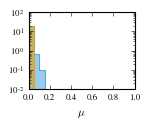

In [148]:
plt.figure(figsize=(3.42/2, 1.2), frameon=False)

# JSL histogram
v, b = np.histogram(mixing_JSL_1_wh, bins=np.linspace(0, 1.0, 21), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#e74c3c", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v, b = np.histogram(mixing_FL_1_wh, bins=np.linspace(0, 1.0, 21), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#3498db", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#3498db", alpha=0.5, label="FL")

# # AL histogram
# v, b = np.histogram(mixing_AL_1_tmp, bins=np.linspace(0, 1.0, 21), normed=True)
# plt.step(b, [v[0]] + list(v), where='pre', color="#1abc9c", lw=0.5)
# b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
# plt.fill_between(b_step, v_step, color="#1abc9c", alpha=0.5, label="JSL")

# AL histogram
v, b = np.histogram(mixing_NL_1_tmp, bins=np.linspace(0, 1.0, 21), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#f1c40f", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#f1c40f", alpha=0.5, label="JSL")

plt.xlabel("$\mu$")
plt.yscale("log")

#plt.legend(frameon=False)
plt.savefig("figures/mixing_coef_distribution_sensibleDTU_wh.pdf")
plt.show()

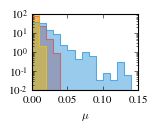

In [147]:
plt.figure(figsize=(3.42/2, 1.2), frameon=False)

# JSL histogram
v, b = np.histogram(mixing_JSL_1_wh, normed=True, bins=np.linspace(0, 0.15, 16))
plt.step(b, [v[0]] + list(v), where='pre', color="#e74c3c", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v, b = np.histogram(mixing_FL_1_wh, normed=True, bins=np.linspace(0, 0.15, 16))
plt.step(b, [v[0]] + list(v), where='pre', color="#3498db", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#3498db", alpha=0.5, label="FL")

# AL histogram
# v, b = np.histogram(mixing_AL_1_wh, normed=True, bins=np.linspace(0, 0.15, 16))
# plt.step(b, [v[0]] + list(v), where='pre', color="#1abc9c", lw=0.5)
# b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
# plt.fill_between(b_step, v_step, color="#1abc9c", alpha=0.5, label="JSL")

# NL histogram
v, b = np.histogram(mixing_NL_1_wh, normed=True, bins=np.linspace(0, 0.15, 16))
plt.step(b, [v[0]] + list(v), where='pre', color="#f1c40f", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#f1c40f", alpha=0.5, label="JSL")

plt.xlabel("$\mu$")
plt.yscale("log")
plt.xlim(0, 0.15)
plt.xticks([0, 0.05, 0.10, 0.15], fontsize=10)
plt.yticks(fontsize=10)

#plt.legend(frameon=False)
plt.savefig("figures/mixing_coef_distribution_sensibleDTU_wh_inset.pdf")
plt.show()

#### Free hours

In [83]:
mixing_JSL_1_fh = compute_mixing_layer_commu(layer_commu_pred_JSL_1_fh_arr, network1_fh, parallel=True)
mixing_FL_1_fh = compute_mixing_layer_commu(layer_commu_pred_FL_1_fh_arr, network1_fh, parallel=True)
mixing_AL_1_fh = compute_mixing_layer_commu(layer_commu_pred_AL_1_fh_arr, network1_fh, parallel=True)
mixing_NL_1_fh = compute_mixing_layer_commu(layer_commu_pred_NL_1_fh_arr, network1_fh, parallel=True)

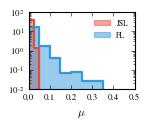

In [150]:
plt.figure(figsize=(3.42/2, 1.2), frameon=False)

# JSL histogram
v_JSL, b_JSL = np.histogram(mixing_JSL_1_fh, bins=np.linspace(0, 0.5, 21), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=2)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v_FL, b_FL = np.histogram(mixing_FL_1_fh, bins=np.linspace(0, 0.5, 11), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=2)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

plt.xlabel("$\mu$")
plt.yscale("log")

plt.legend(frameon=False)
plt.savefig("figures/mixing_coef_distribution_sensibleDTU_fh.pdf")
plt.show()

### Community overlap/entropy

#### Working hours

In [86]:
# List of communities that each node participates in, from each solution
communities_JSL_1_wh_arr = [node_communities(layer_commu_pred_JSL_1_wh) for layer_commu_pred_JSL_1_wh in layer_commu_pred_JSL_1_wh_arr] 
communities_FL_1_wh_arr = [node_communities(layer_commu_pred_FL_1_wh) for layer_commu_pred_FL_1_wh in layer_commu_pred_FL_1_wh_arr] 
communities_AL_1_wh_arr = [node_communities(layer_commu_pred_AL_1_wh) for layer_commu_pred_AL_1_wh in layer_commu_pred_AL_1_wh_arr] 
communities_NL_1_wh_arr = [node_communities(layer_commu_pred_NL_1_wh) for layer_commu_pred_NL_1_wh in layer_commu_pred_NL_1_wh_arr] 

# Compute entropy and overlap for each user
entropy_JSL_1_wh_arr, overlap_JSL_1_wh_arr = zip(*[compute_entropy_and_overlap(communities_JSL_1_wh) for communities_JSL_1_wh in communities_JSL_1_wh_arr])
entropy_FL_1_wh_arr, overlap_FL_1_wh_arr = zip(*[compute_entropy_and_overlap(communities_FL_1_wh) for communities_FL_1_wh in communities_FL_1_wh_arr])
entropy_AL_1_wh_arr, overlap_AL_1_wh_arr = zip(*[compute_entropy_and_overlap(communities_AL_1_wh) for communities_AL_1_wh in communities_AL_1_wh_arr])
entropy_NL_1_wh_arr, overlap_NL_1_wh_arr = zip(*[compute_entropy_and_overlap(communities_NL_1_wh) for communities_NL_1_wh in communities_NL_1_wh_arr])

# Ravel arrays-of-arrays to arrays
entropy_JSL_1_wh, overlap_JSL_1_wh = ravel_two_level(entropy_JSL_1_wh_arr), ravel_two_level(overlap_JSL_1_wh_arr)
entropy_FL_1_wh, overlap_FL_1_wh = ravel_two_level(entropy_FL_1_wh_arr), ravel_two_level(overlap_FL_1_wh_arr)
entropy_AL_1_wh, overlap_AL_1_wh = ravel_two_level(entropy_AL_1_wh_arr), ravel_two_level(overlap_AL_1_wh_arr)
entropy_NL_1_wh, overlap_NL_1_wh = ravel_two_level(entropy_NL_1_wh_arr), ravel_two_level(overlap_NL_1_wh_arr)

##### Overlap

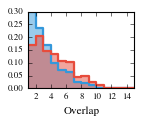

In [155]:
plt.figure(figsize=(3.42/2, 1.2), frameon=False)

# FL histogram
v_FL, b_FL = np.histogram(overlap_FL_1_wh, bins=np.linspace(1, 15, 15), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=2)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# JSL histogram
v_JSL, b_JSL = np.histogram(overlap_JSL_1_wh, bins=np.linspace(1, 15, 15), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=2)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

plt.xlabel("overlap".capitalize())

plt.xlim(1, 15)

#plt.legend(frameon=False)
plt.savefig("figures/overlap_distribution_sensibleDTU_wh.pdf")
plt.show()

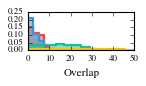

In [157]:
plt.figure(figsize=(3.42/2, 2.4/4), frameon=False)

# JSL histogram
v_JSL, b_JSL = np.histogram(overlap_JSL_1_wh, bins=np.linspace(0, 30, 13), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=2)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v_FL, b_FL = np.histogram(overlap_FL_1_wh, bins=np.linspace(0, 30, 13), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=2)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# AL histogram
v_AL, b_AL = np.histogram(overlap_AL_1_wh, normed=True)#, bins=np.logspace(0, np.log10(200), 15))
plt.step(b_AL, [v_AL[0]] + list(v_AL), where='pre', color="#1abc9c", lw=2)
b_AL_step, v_AL_step = get_x_y_steps(b_AL, [v_AL[0]] + list(v_AL), where="pre")
plt.fill_between(b_AL_step, v_AL_step, color="#1abc9c", alpha=0.5, label="AL")

# # NL histogram
v_NL, b_NL = np.histogram(overlap_NL_1_wh, normed=True)
plt.step(b_NL, [v_NL[0]] + list(v_NL), where='pre', color="#f1c40f", lw=2)
b_NL_step, v_NL_step = get_x_y_steps(b_NL, [v_NL[0]] + list(v_NL), where="pre")
plt.fill_between(b_NL_step, v_NL_step, color="#f1c40f", alpha=0.5, label="NL")

#plt.yticks([0, 0.05, 0.1])
plt.xlabel("overlap".capitalize())
plt.xlim(0, 50)

#plt.legend(frameon=False)
plt.savefig("figures/overlap_distribution_sensibleDTU_wh_all_distr_wide.pdf")
plt.show()

/usr/local/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:407: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*sqrt(a + b + 1) / (a + b + 2) / sqrt(a*b)


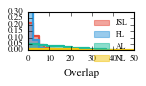

In [158]:
alpha_JSL_1_wh, beta_JSL_1_wh, loc_JSL_1_wh, scale_JSL_1_wh = sp.stats.beta.fit(overlap_JSL_1_wh)
alpha_FL_1_wh, beta_FL_1_wh, loc_FL_1_wh, scale_FL_1_wh = sp.stats.beta.fit(overlap_FL_1_wh)
alpha_AL_1_wh, beta_AL_1_wh, loc_AL_1_wh, scale_AL_1_wh = sp.stats.beta.fit(overlap_AL_1_wh)
alpha_NL_1_wh, beta_NL_1_wh, loc_NL_1_wh, scale_NL_1_wh = sp.stats.beta.fit(overlap_NL_1_wh)

overlap_fit_samples_JSL_1_wh = sp.stats.beta.rvs(alpha_JSL_1_wh, beta_JSL_1_wh, loc_JSL_1_wh, scale_JSL_1_wh, size=10000)
overlap_fit_samples_FL_1_wh = sp.stats.beta.rvs(alpha_FL_1_wh, beta_FL_1_wh, loc_FL_1_wh, scale_FL_1_wh, size=10000)
overlap_fit_samples_AL_1_wh = sp.stats.beta.rvs(alpha_AL_1_wh, beta_AL_1_wh, loc_AL_1_wh, scale_AL_1_wh, size=10000)
overlap_fit_samples_NL_1_wh = sp.stats.beta.rvs(alpha_NL_1_wh, beta_NL_1_wh, loc_NL_1_wh, scale_NL_1_wh, size=10000)

plt.figure(figsize=(3.42/2, 2.4/4), frameon=False)

# JSL histogram
v_JSL, b_JSL = np.histogram(overlap_fit_samples_JSL_1_wh, bins=np.linspace(0, 30, 13), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=2)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v_FL, b_FL = np.histogram(overlap_fit_samples_FL_1_wh, bins=np.linspace(0, 30, 13), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=2)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# AL histogram
v_AL, b_AL = np.histogram(overlap_fit_samples_AL_1_wh, normed=True)#, bins=np.logspace(0, np.log10(200), 15))
plt.step(b_AL, [v_AL[0]] + list(v_AL), where='pre', color="#1abc9c", lw=2)
b_AL_step, v_AL_step = get_x_y_steps(b_AL, [v_AL[0]] + list(v_AL), where="pre")
plt.fill_between(b_AL_step, v_AL_step, color="#1abc9c", alpha=0.5, label="AL")

# NL histogram
v_NL, b_NL = np.histogram(overlap_fit_samples_NL_1_wh, normed=True)
plt.step(b_NL, [v_NL[0]] + list(v_NL), where='pre', color="#f1c40f", lw=2)
b_NL_step, v_NL_step = get_x_y_steps(b_NL, [v_NL[0]] + list(v_NL), where="pre")
plt.fill_between(b_NL_step, v_NL_step, color="#f1c40f", alpha=0.5, label="NL")

plt.xlabel("overlap".capitalize())
plt.xlim(0, 50)

plt.legend(frameon=False)
plt.savefig("figures/overlap_distribution_sensibleDTU_wh_all_distr_beta_fit_wide.pdf")
plt.show()

##### Entropy

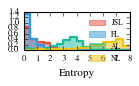

In [160]:
plt.figure(figsize=(3.42/2, 1.2/2), frameon=False)

# JSL histogram
v_JSL, b_JSL = np.histogram(entropy_JSL_1_wh, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=2)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v_FL, b_FL = np.histogram(entropy_FL_1_wh, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=2)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# AL histogram
v_AL, b_AL = np.histogram(entropy_AL_1_wh, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_AL, [v_AL[0]] + list(v_AL), where='pre', color="#1abc9c", lw=2)
b_AL_step, v_AL_step = get_x_y_steps(b_AL, [v_AL[0]] + list(v_AL), where="pre")
plt.fill_between(b_AL_step, v_AL_step, color="#1abc9c", alpha=0.5, label="AL")

# NL histogram
v_NL, b_NL = np.histogram(entropy_NL_1_wh, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_NL, [v_NL[0]] + list(v_NL), where='pre', color="#f1c40f", lw=2)
b_NL_step, v_NL_step = get_x_y_steps(b_NL, [v_NL[0]] + list(v_NL), where="pre")
plt.fill_between(b_NL_step, v_NL_step, color="#f1c40f", alpha=0.5, label="NL")

plt.xlabel("entropy".capitalize())
plt.xlim(0)

plt.legend(frameon=False)
plt.savefig("figures/entropy_distribution_sensibleDTU_wh_all_distr_wide.pdf")
plt.show()

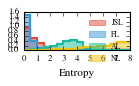

In [161]:
alpha_JSL_1_wh, beta_JSL_1_wh, loc_JSL_1_wh, scale_JSL_1_wh = sp.stats.beta.fit(entropy_JSL_1_wh)
alpha_FL_1_wh, beta_FL_1_wh, loc_FL_1_wh, scale_FL_1_wh = sp.stats.beta.fit(entropy_FL_1_wh)
alpha_AL_1_wh, beta_AL_1_wh, loc_AL_1_wh, scale_AL_1_wh = sp.stats.beta.fit(entropy_AL_1_wh)
alpha_NL_1_wh, beta_NL_1_wh, loc_NL_1_wh, scale_NL_1_wh = sp.stats.beta.fit(entropy_NL_1_wh)

entropy_fit_samples_JSL_1_wh = sp.stats.beta.rvs(alpha_JSL_1_wh, beta_JSL_1_wh, loc_JSL_1_wh, scale_JSL_1_wh, size=10000)
entropy_fit_samples_FL_1_wh = sp.stats.beta.rvs(alpha_FL_1_wh, beta_FL_1_wh, loc_FL_1_wh, scale_FL_1_wh, size=10000)
entropy_fit_samples_AL_1_wh = sp.stats.beta.rvs(alpha_AL_1_wh, beta_AL_1_wh, loc_AL_1_wh, scale_AL_1_wh, size=10000)
entropy_fit_samples_NL_1_wh = sp.stats.beta.rvs(alpha_NL_1_wh, beta_NL_1_wh, loc_NL_1_wh, scale_NL_1_wh, size=10000)

plt.figure(figsize=(3.42/2, 2.4/4), frameon=False)

# JSL histogram
v_JSL, b_JSL = np.histogram(entropy_fit_samples_JSL_1_wh, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=2)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v_FL, b_FL = np.histogram(entropy_fit_samples_FL_1_wh, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=2)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# AL histogram
v_AL, b_AL = np.histogram(entropy_fit_samples_AL_1_wh, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_AL, [v_AL[0]] + list(v_AL), where='pre', color="#1abc9c", lw=2)
b_AL_step, v_AL_step = get_x_y_steps(b_AL, [v_AL[0]] + list(v_AL), where="pre")
plt.fill_between(b_AL_step, v_AL_step, color="#1abc9c", alpha=0.5, label="AL")

# NL histogram
v_NL, b_NL = np.histogram(entropy_fit_samples_NL_1_wh, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_NL, [v_NL[0]] + list(v_NL), where='pre', color="#f1c40f", lw=2)
b_NL_step, v_NL_step = get_x_y_steps(b_NL, [v_NL[0]] + list(v_NL), where="pre")
plt.fill_between(b_NL_step, v_NL_step, color="#f1c40f", alpha=0.5, label="NL")

plt.xlabel("entropy".capitalize())
plt.xlim(0)

plt.legend(frameon=False)
plt.savefig("figures/entropy_distribution_sensibleDTU_wh_all_distr_beta_fit_wide.pdf")
plt.show()

#### Free hours

In [168]:
# List of communities that each node participates in, from each solution
communities_JSL_1_fh_arr = [node_communities(layer_commu_pred_JSL_1_fh) for layer_commu_pred_JSL_1_fh in layer_commu_pred_JSL_1_fh_arr] 
communities_FL_1_fh_arr = [node_communities(layer_commu_pred_FL_1_fh) for layer_commu_pred_FL_1_fh in layer_commu_pred_FL_1_fh_arr] 
communities_AL_1_fh_arr = [node_communities(layer_commu_pred_AL_1_fh) for layer_commu_pred_AL_1_fh in layer_commu_pred_AL_1_fh_arr] 
communities_NL_1_fh_arr = [node_communities(layer_commu_pred_NL_1_fh) for layer_commu_pred_NL_1_fh in layer_commu_pred_NL_1_fh_arr] 

# Compute entropy and overlap for each user
entropy_JSL_1_fh_arr, overlap_JSL_1_fh_arr = zip(*[compute_entropy_and_overlap(communities_JSL_1_fh) for communities_JSL_1_fh in communities_JSL_1_fh_arr])
entropy_FL_1_fh_arr, overlap_FL_1_fh_arr = zip(*[compute_entropy_and_overlap(communities_FL_1_fh) for communities_FL_1_fh in communities_FL_1_fh_arr])
entropy_AL_1_fh_arr, overlap_AL_1_fh_arr = zip(*[compute_entropy_and_overlap(communities_AL_1_fh) for communities_AL_1_fh in communities_AL_1_fh_arr])
entropy_NL_1_fh_arr, overlap_NL_1_fh_arr = zip(*[compute_entropy_and_overlap(communities_NL_1_fh) for communities_NL_1_fh in communities_NL_1_fh_arr])

# Ravel arrays-of-arrays to arrays
entropy_JSL_1_fh, overlap_JSL_1_fh = ravel_two_level(entropy_JSL_1_fh_arr), ravel_two_level(overlap_JSL_1_fh_arr)
entropy_FL_1_fh, overlap_FL_1_fh = ravel_two_level(entropy_FL_1_fh_arr), ravel_two_level(overlap_FL_1_fh_arr)
entropy_AL_1_fh, overlap_AL_1_fh = ravel_two_level(entropy_AL_1_fh_arr), ravel_two_level(overlap_AL_1_fh_arr)
entropy_NL_1_fh, overlap_NL_1_fh = ravel_two_level(entropy_NL_1_fh_arr), ravel_two_level(overlap_NL_1_fh_arr)

##### Overlap

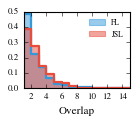

In [169]:
plt.figure(figsize=(3.42/2, 1.2), frameon=False)

# FL histogram
v_FL, b_FL = np.histogram(overlap_FL_1_fh, bins=np.linspace(1, 15, 15), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=2)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# JSL histogram
v_JSL, b_JSL = np.histogram(overlap_JSL_1_fh, bins=np.linspace(1, 15, 15), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=2)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

plt.xlabel("overlap".capitalize())
#plt.yscale("log")

plt.xlim(1, 15)

plt.legend(frameon=False)
plt.savefig("figures/overlap_distribution_sensibleDTU_fh.pdf")
plt.show()

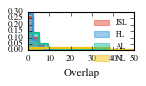

In [170]:
plt.figure(figsize=(3.42/2, 2.4/4), frameon=False)

# JSL histogram
v_JSL, b_JSL = np.histogram(overlap_JSL_1_fh, bins=np.linspace(0, 30, 13), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=2)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v_FL, b_FL = np.histogram(overlap_FL_1_fh, bins=np.linspace(0, 30, 13), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=2)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# AL histogram
v_AL, b_AL = np.histogram(overlap_AL_1_fh, normed=True)#, bins=np.logspace(0, np.log10(200), 15))
plt.step(b_AL, [v_AL[0]] + list(v_AL), where='pre', color="#1abc9c", lw=2)
b_AL_step, v_AL_step = get_x_y_steps(b_AL, [v_AL[0]] + list(v_AL), where="pre")
plt.fill_between(b_AL_step, v_AL_step, color="#1abc9c", alpha=0.5, label="AL")

# # NL histogram
v_NL, b_NL = np.histogram(overlap_NL_1_fh, normed=True)
plt.step(b_NL, [v_NL[0]] + list(v_NL), where='pre', color="#f1c40f", lw=2)
b_NL_step, v_NL_step = get_x_y_steps(b_NL, [v_NL[0]] + list(v_NL), where="pre")
plt.fill_between(b_NL_step, v_NL_step, color="#f1c40f", alpha=0.5, label="NL")

#plt.yticks([0, 0.05, 0.1])
plt.xlabel("overlap".capitalize())
plt.xlim(0, 50)

plt.legend(frameon=False)
plt.savefig("figures/overlap_distribution_sensibleDTU_fh_all_distr_wide.pdf")
plt.show()

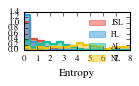

In [171]:
plt.figure(figsize=(3.42/2, 1.2/2), frameon=False)

# JSL histogram
v_JSL, b_JSL = np.histogram(entropy_JSL_1_fh, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=2)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v_FL, b_FL = np.histogram(entropy_FL_1_fh, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=2)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# AL histogram
v_AL, b_AL = np.histogram(entropy_AL_1_fh, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_AL, [v_AL[0]] + list(v_AL), where='pre', color="#1abc9c", lw=2)
b_AL_step, v_AL_step = get_x_y_steps(b_AL, [v_AL[0]] + list(v_AL), where="pre")
plt.fill_between(b_AL_step, v_AL_step, color="#1abc9c", alpha=0.5, label="AL")

# NL histogram
v_NL, b_NL = np.histogram(entropy_NL_1_fh, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_NL, [v_NL[0]] + list(v_NL), where='pre', color="#f1c40f", lw=2)
b_NL_step, v_NL_step = get_x_y_steps(b_NL, [v_NL[0]] + list(v_NL), where="pre")
plt.fill_between(b_NL_step, v_NL_step, color="#f1c40f", alpha=0.5, label="NL")

plt.xlabel("entropy".capitalize())
plt.xlim(0)

plt.legend(frameon=False)
plt.savefig("figures/entropy_distribution_sensibleDTU_all_distr_wide.pdf")
plt.show()

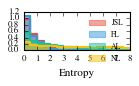

In [166]:
alpha_JSL_1_fh, beta_JSL_1_fh, loc_JSL_1_fh, scale_JSL_1_fh = sp.stats.beta.fit(entropy_JSL_1_fh)
alpha_FL_1_fh, beta_FL_1_fh, loc_FL_1_fh, scale_FL_1_fh = sp.stats.beta.fit(entropy_FL_1_fh)
alpha_AL_1_fh, beta_AL_1_fh, loc_AL_1_fh, scale_AL_1_fh = sp.stats.beta.fit(entropy_AL_1_fh)
alpha_NL_1_fh, beta_NL_1_fh, loc_NL_1_fh, scale_NL_1_fh = sp.stats.beta.fit(entropy_NL_1_fh)

entropy_fit_samples_JSL_1_fh = sp.stats.beta.rvs(alpha_JSL_1_fh, beta_JSL_1_fh, loc_JSL_1_fh, scale_JSL_1_fh, size=10000)
entropy_fit_samples_FL_1_fh = sp.stats.beta.rvs(alpha_FL_1_fh, beta_FL_1_fh, loc_FL_1_fh, scale_FL_1_fh, size=10000)
entropy_fit_samples_AL_1_fh = sp.stats.beta.rvs(alpha_AL_1_fh, beta_AL_1_fh, loc_AL_1_fh, scale_AL_1_fh, size=10000)
entropy_fit_samples_NL_1_fh = sp.stats.beta.rvs(alpha_NL_1_fh, beta_NL_1_fh, loc_NL_1_fh, scale_NL_1_fh, size=10000)

plt.figure(figsize=(3.42/2, 2.4/4), frameon=False)

# JSL histogram
v_JSL, b_JSL = np.histogram(entropy_fit_samples_JSL_1_fh, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=2)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v_FL, b_FL = np.histogram(entropy_fit_samples_FL_1_fh, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=2)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# AL histogram
v_AL, b_AL = np.histogram(entropy_fit_samples_AL_1_fh, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_AL, [v_AL[0]] + list(v_AL), where='pre', color="#1abc9c", lw=2)
b_AL_step, v_AL_step = get_x_y_steps(b_AL, [v_AL[0]] + list(v_AL), where="pre")
plt.fill_between(b_AL_step, v_AL_step, color="#1abc9c", alpha=0.5, label="AL")

# NL histogram
v_NL, b_NL = np.histogram(entropy_fit_samples_NL_1_fh, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_NL, [v_NL[0]] + list(v_NL), where='pre', color="#f1c40f", lw=2)
b_NL_step, v_NL_step = get_x_y_steps(b_NL, [v_NL[0]] + list(v_NL), where="pre")
plt.fill_between(b_NL_step, v_NL_step, color="#f1c40f", alpha=0.5, label="NL")

plt.xlabel("entropy".capitalize())
plt.xlim(0)

plt.legend(frameon=False)
plt.savefig("figures/entropy_distribution_sensibleDTU_fh_all_distr_beta_fit_wide.pdf")
plt.show()

### Solution NMI

#### Working hours

In [174]:
print "JSL"

print "\tstudent_study_line", np.mean([
        np.mean(solution_average_NMI(layer_commu_pred_JSL_1_wh, student_study_line))
        for layer_commu_pred_JSL_1_wh in layer_commu_pred_JSL_1_wh_arr
    ]
)
print "\tshuffle_dict_kvs(student_study_line)", np.mean([
        np.mean(solution_average_NMI(layer_commu_pred_JSL_1_wh, shuffle_dict_kvs(student_study_line)))
        for layer_commu_pred_JSL_1_wh in layer_commu_pred_JSL_1_wh_arr
    ]
)
print "\tstudent_vector_group", np.mean([
        np.mean(solution_average_NMI(layer_commu_pred_JSL_1_wh, student_vector_group))
        for layer_commu_pred_JSL_1_wh in layer_commu_pred_JSL_1_wh_arr
    ]
)
print "\tshuffle_dict_kvs(student_vector_group)", np.mean([
        np.mean(solution_average_NMI(layer_commu_pred_JSL_1_wh, shuffle_dict_kvs(student_vector_group)))
        for layer_commu_pred_JSL_1_wh in layer_commu_pred_JSL_1_wh_arr
    ]
)

print "\nFL"

print "\tstudent_study_line", np.mean([
        np.mean(solution_average_NMI(layer_commu_pred_FL_1_wh, student_study_line))
        for layer_commu_pred_FL_1_wh in layer_commu_pred_FL_1_wh_arr
    ]
)
print "\tshuffle_dict_kvs(student_study_line)", np.mean([
        np.mean(solution_average_NMI(layer_commu_pred_FL_1_wh, shuffle_dict_kvs(student_study_line)))
        for layer_commu_pred_FL_1_wh in layer_commu_pred_FL_1_wh_arr
    ]
)
print "\tstudent_vector_group", np.mean([
        np.mean(solution_average_NMI(layer_commu_pred_FL_1_wh, student_vector_group))
        for layer_commu_pred_FL_1_wh in layer_commu_pred_FL_1_wh_arr
    ]
)
print "\tshuffle_dict_kvs(student_vector_group)", np.mean([
        np.mean(solution_average_NMI(layer_commu_pred_FL_1_wh, shuffle_dict_kvs(student_vector_group)))
        for layer_commu_pred_FL_1_wh in layer_commu_pred_FL_1_wh_arr
    ]
)

JSL
	student_study_line 0.823912185896
	shuffle_dict_kvs(student_study_line) 0.497664143785
	student_vector_group 0.843879384929
	shuffle_dict_kvs(student_vector_group) 0.755668912645

FL
	student_study_line 0.837398696121
	shuffle_dict_kvs(student_study_line) 0.482519386051
	student_vector_group 0.834798681092
	shuffle_dict_kvs(student_vector_group) 0.733569641567


#### Free hours

In [173]:
print "student_study_line", np.mean([
        np.mean(solution_average_NMI(layer_commu_pred_JSL_1_fh, student_study_line))
        for layer_commu_pred_JSL_1_fh in layer_commu_pred_JSL_1_fh_arr
    ]
    
)
print "shuffle_dict_kvs(student_study_line)", np.mean([
        np.mean(solution_average_NMI(layer_commu_pred_JSL_1_fh, shuffle_dict_kvs(student_study_line)))
        for layer_commu_pred_JSL_1_fh in layer_commu_pred_JSL_1_fh_arr
    ]
    
)
print "student_vector_group", np.mean([
        np.mean(solution_average_NMI(layer_commu_pred_JSL_1_fh, student_vector_group))
        for layer_commu_pred_JSL_1_fh in layer_commu_pred_JSL_1_fh_arr
    ]
    
)
print "shuffle_dict_kvs(student_vector_group)", np.mean([
        np.mean(solution_average_NMI(layer_commu_pred_JSL_1_fh, shuffle_dict_kvs(student_vector_group)))
        for layer_commu_pred_JSL_1_fh in layer_commu_pred_JSL_1_fh_arr
    ]
    
)

student_study_line 0.73514635974
shuffle_dict_kvs(student_study_line) 0.705187282261
student_vector_group 0.907199162613
shuffle_dict_kvs(student_vector_group) 0.896242515222


### Community entropy

#### Working hours

In [321]:
commu_entropy_JSL_1_wh_arr = [compute_community_entropy(layer_commu_pred_JSL_1_wh, student_study_line) for layer_commu_pred_JSL_1_wh in layer_commu_pred_JSL_1_wh_arr]
commu_entropy_FL_1_wh_arr = [compute_community_entropy(layer_commu_pred_FL_1_wh, student_study_line) for layer_commu_pred_FL_1_wh in layer_commu_pred_FL_1_wh_arr]
commu_entropy_AL_1_wh_arr = [compute_community_entropy(layer_commu_pred_AL_1_wh, student_study_line) for layer_commu_pred_AL_1_wh in layer_commu_pred_AL_1_wh_arr]
commu_entropy_NL_1_wh_arr = [compute_community_entropy(layer_commu_pred_NL_1_wh, student_study_line) for layer_commu_pred_NL_1_wh in layer_commu_pred_NL_1_wh_arr]

commu_entropy_JSL_1_wh = ravel_two_level(commu_entropy_JSL_1_wh_arr)
commu_entropy_FL_1_wh = ravel_two_level(commu_entropy_FL_1_wh_arr)
commu_entropy_AL_1_wh = ravel_two_level(commu_entropy_AL_1_wh_arr)
commu_entropy_NL_1_wh = ravel_two_level(commu_entropy_NL_1_wh_arr)

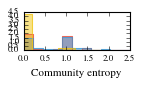

In [322]:
plt.figure(figsize=(3.42/2, 2.4/4), frameon=False)

# JSL histogram
v, b = np.histogram(commu_entropy_JSL_1_wh, bins=np.linspace(0, 2.5, 12), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#e74c3c", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v, b = np.histogram(commu_entropy_FL_1_wh, bins=np.linspace(0, 2.5, 12), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#3498db", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#3498db", alpha=0.5, label="FL")

# # AL histogram
# v, b = np.histogram(commu_entropy_AL_1_wh, bins=np.linspace(0, 2, 11), normed=True)
# plt.step(b, [v[0]] + list(v), where='pre', color="#1abc9c", lw=0.5)
# b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
# plt.fill_between(b_step, v_step, color="#1abc9c", alpha=0.5, label="AL")

# NL histogram
v, b = np.histogram(commu_entropy_NL_1_wh, bins=np.linspace(0, 2, 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#f1c40f", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#f1c40f", alpha=0.5, label="NL")

plt.xlabel("community entropy".capitalize())
#plt.xlim(0, 2)
#plt.yscale("log")

#plt.legend(frameon=False)
plt.savefig("figures/commu_entropy_distribution_sensibleDTU_all_distr_wide.pdf")
plt.show()

### Size distribution

In [208]:
sizes_JSL_2_arr = [compute_community_size(layer_commu_pred_JSL_2, network2) for layer_commu_pred_JSL_2 in layer_commu_pred_JSL_2_arr]
sizes_FL_2_arr = [compute_community_size(layer_commu_pred_FL_2, network2) for layer_commu_pred_FL_2 in layer_commu_pred_FL_2_arr]
sizes_AL_2_arr = [compute_community_size(layer_commu_pr ed_AL_2, network2) for layer_commu_pred_AL_2 in layer_commu_pred_AL_2_arr]
sizes_NL_2_arr = [compute_community_size(layer_commu_pred_NL_2, network2) for layer_commu_pred_NL_2 in layer_commu_pred_NL_2_arr]

sizes_JSL_2 = ravel_two_level(sizes_JSL_2_arr)
sizes_FL_2 = ravel_two_level(sizes_FL_2_arr)
sizes_AL_2 = ravel_two_level(sizes_AL_2_arr)
sizes_NL_2 = ravel_two_level(sizes_NL_2_arr)

In [ ]:
# Doesn't fit a powerlaw!
# x = np.linspace(0, 0.2, 100)
# y_JSL = sp.stats.powerlaw.pdf(x, *sp.stats.powerlaw.fit(sizes_JSL_2))
# y_FL = sp.stats.powerlaw.pdf(x, *sp.stats.powerlaw.fit(sizes_FL_2))
# y_AL = sp.stats.powerlaw.pdf(x, *sp.stats.powerlaw.fit(sizes_AL_2))
# y_NL = sp.stats.powerlaw.pdf(x, *sp.stats.powerlaw.fit(sizes_NL_2))

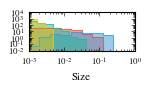

In [315]:
plt.figure(figsize=(3.42/2, 2.4/4), frameon=False)

# JSL histogram
v, b = np.histogram(sizes_JSL_2, np.logspace(np.log10(1e-3), np.log10(1), 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#e74c3c", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#e74c3c", alpha=0.5, label="JSL")
#plt.plot(x, y_JSL, color="#e74c3c", lw=2)

# FL histogram
v, b = np.histogram(sizes_FL_2, np.logspace(np.log10(1e-3), np.log10(1), 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#3498db", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#3498db", alpha=0.5, label="FL")
#plt.plot(x, y_FL, color="#3498db", lw=2)

# AL histogram
v, b = np.histogram(sizes_AL_2, np.logspace(np.log10(1e-3), np.log10(0.2), 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#1abc9c", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#1abc9c", alpha=0.5, label="AL")
#plt.plot(x, y_AL, color="#1abc9c", lw=2)

# NL histogram
v, b = np.histogram(sizes_NL_2, np.logspace(np.log10(1e-3), np.log10(0.2), 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#f1c40f", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#f1c40f", alpha=0.5, label="NL")
#plt.plot(x, y_NL, color="#f1c40f", lw=2)

plt.yscale("log")
plt.xscale("log")

plt.xlabel("size".capitalize())
plt.xlim(1e-3)

#plt.legend(frameon=False)
plt.savefig("figures/size_distribution_workplace_all_distr_wide_loglog.pdf")
plt.show()

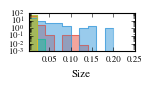

In [316]:
plt.figure(figsize=(3.42/2, 2.4/4), frameon=False)

# JSL histogram
v, b = np.histogram(sizes_JSL_2, np.linspace(0, 0.2, 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#e74c3c", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#e74c3c", alpha=0.5, label="JSL")
#plt.plot(x, y_JSL, color="#e74c3c")

# FL histogram
v, b = np.histogram(sizes_FL_2, np.linspace(0, 0.2, 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#3498db", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#3498db", alpha=0.5, label="FL")
#plt.plot(x, y_FL, color="#3498db")

# AL histogram
v, b = np.histogram(sizes_AL_2, np.linspace(0, 0.2, 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#1abc9c", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#1abc9c", alpha=0.5, label="AL")
#plt.plot(x, y_AL, color="#1abc9c")

# NL histogram
v, b = np.histogram(sizes_NL_2, np.linspace(0, 0.2, 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#f1c40f", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#f1c40f", alpha=0.5, label="NL")
#plt.plot(x, y_NL, color="#f1c40f")

plt.yscale("log")

plt.xlabel("size".capitalize())
plt.xlim(1e-3)

#plt.legend(frameon=False)
plt.savefig("figures/size_distribution_workplace_all_distr_wide_log.pdf")
plt.show()

## *Workplace*

### Create many solutions

In [175]:
layer_commu_pred_JSL_2_arr, layer_commu_pred_FL_2_arr, layer_commu_pred_AL_2_arr, layer_commu_pred_NL_2_arr = compute_layer_commu_4_models(network_pajek2, network2, layer_indices2, "2", 0, parallel=True)

### Degree of mixing

In [176]:
mixing_JSL_2 = compute_mixing_layer_commu(layer_commu_pred_JSL_2_arr, network2, parallel=True)
mixing_FL_2 = compute_mixing_layer_commu(layer_commu_pred_FL_2_arr, network2, parallel=True)
mixing_AL_2 = compute_mixing_layer_commu(layer_commu_pred_AL_2_arr, network2, parallel=True)
mixing_NL_2 = compute_mixing_layer_commu(layer_commu_pred_NL_2_arr, network2, parallel=True)

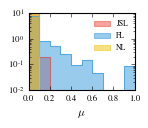

In [184]:
plt.figure(figsize=(3.42/2, 1.2), frameon=False)

# JSL histogram
v_JSL, b_JSL = np.histogram(mixing_JSL_2, bins=np.linspace(0, 1, 11), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=0.5)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v_FL, b_FL = np.histogram(mixing_FL_2, bins=np.linspace(0, 1, 11), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=0.5)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# # AL histogram
# v_AL, b_AL = np.histogram(mixing_AL_2, bins=np.linspace(0, 1, 11), normed=True)
# plt.step(b_AL, [v_AL[0]] + list(v_AL), where='pre', color="#1abc9c", lw=0.5)
# b_AL_step, v_AL_step = get_x_y_steps(b_AL, [v_AL[0]] + list(v_AL), where="pre")
# plt.fill_between(b_AL_step, v_AL_step, color="#1abc9c", alpha=0.5, label="AL")

# NL histogram
v_NL, b_NL = np.histogram(mixing_NL_2, bins=np.linspace(0, 1, 11), normed=True)
plt.step(b_NL, [v_NL[0]] + list(v_NL), where='pre', color="#f1c40f", lw=0.5)
b_NL_step, v_NL_step = get_x_y_steps(b_NL, [v_NL[0]] + list(v_NL), where="pre")
plt.fill_between(b_NL_step, v_NL_step, color="#f1c40f", alpha=0.5, label="NL")

plt.xlabel("$\mu$")
plt.yscale("log")

plt.legend(frameon=False)
plt.savefig("figures/mixing_coef_distribution_workplace.pdf")
plt.show()

### Community overlap/entropy

In [179]:
# List of communities that each node participates in, from each solution
communities_JSL_2_arr = [node_communities(layer_commu_pred_JSL_2) for layer_commu_pred_JSL_2 in layer_commu_pred_JSL_2_arr] 
communities_FL_2_arr = [node_communities(layer_commu_pred_FL_2) for layer_commu_pred_FL_2 in layer_commu_pred_FL_2_arr] 
communities_AL_2_arr = [node_communities(layer_commu_pred_AL_2) for layer_commu_pred_AL_2 in layer_commu_pred_AL_2_arr] 
communities_NL_2_arr = [node_communities(layer_commu_pred_NL_2) for layer_commu_pred_NL_2 in layer_commu_pred_NL_2_arr] 

# Compute entropy and overlap for each user
entropy_JSL_2_arr, overlap_JSL_2_arr = zip(*[compute_entropy_and_overlap(communities_JSL_2) for communities_JSL_2 in communities_JSL_2_arr])
entropy_FL_2_arr, overlap_FL_2_arr = zip(*[compute_entropy_and_overlap(communities_FL_2) for communities_FL_2 in communities_FL_2_arr])
entropy_AL_2_arr, overlap_AL_2_arr = zip(*[compute_entropy_and_overlap(communities_AL_2) for communities_AL_2 in communities_AL_2_arr])
entropy_NL_2_arr, overlap_NL_2_arr = zip(*[compute_entropy_and_overlap(communities_NL_2) for communities_NL_2 in communities_NL_2_arr])

# Ravel arrays-of-arrays to arrays
entropy_JSL_2, overlap_JSL_2 = ravel_two_level(entropy_JSL_2_arr), ravel_two_level(overlap_JSL_2_arr)
entropy_FL_2, overlap_FL_2 = ravel_two_level(entropy_FL_2_arr), ravel_two_level(overlap_FL_2_arr)
entropy_AL_2, overlap_AL_2 = ravel_two_level(entropy_AL_2_arr), ravel_two_level(overlap_AL_2_arr)
entropy_NL_2, overlap_NL_2 = ravel_two_level(entropy_NL_2_arr), ravel_two_level(overlap_NL_2_arr)

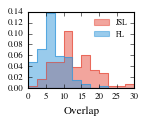

In [185]:
plt.figure(figsize=(3.42/2, 1.2), frameon=False)

# JSL histogram
v_JSL, b_JSL = np.histogram(overlap_JSL_2, bins=np.linspace(0, 30, 13), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=0.5)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v_FL, b_FL = np.histogram(overlap_FL_2, bins=np.linspace(0, 30, 13), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=0.5)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

plt.xlabel("overlap".capitalize())

plt.legend(frameon=False)
plt.savefig("figures/overlap_distribution_workplace.pdf")
plt.show()

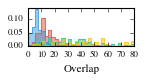

In [194]:
plt.figure(figsize=(3.42/2, 2.4/4), frameon=False)

# JSL histogram
v_JSL, b_JSL = np.histogram(overlap_JSL_2, bins=np.linspace(0, 80, 33), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=0.5)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v_FL, b_FL = np.histogram(overlap_FL_2, bins=np.linspace(0, 80, 33), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=0.5)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# AL histogram
v_AL, b_AL = np.histogram(overlap_AL_2, bins=np.linspace(0, 80, 33), normed=True)
plt.step(b_AL, [v_AL[0]] + list(v_AL), where='pre', color="#1abc9c", lw=0.5)
b_AL_step, v_AL_step = get_x_y_steps(b_AL, [v_AL[0]] + list(v_AL), where="pre")
plt.fill_between(b_AL_step, v_AL_step, color="#1abc9c", alpha=0.5, label="AL")

# # NL histogram
v_NL, b_NL = np.histogram(overlap_NL_2, bins=np.linspace(0, 80, 33), normed=True)
plt.step(b_NL, [v_NL[0]] + list(v_NL), where='pre', color="#f1c40f", lw=0.5)
b_NL_step, v_NL_step = get_x_y_steps(b_NL, [v_NL[0]] + list(v_NL), where="pre")
plt.fill_between(b_NL_step, v_NL_step, color="#f1c40f", alpha=0.5, label="NL")

plt.yticks([0, 0.05, 0.1])
plt.xlabel("overlap".capitalize())
#plt.xlim(0, 80)

#plt.legend(frameon=False)
plt.savefig("figures/overlap_distribution_workplace_all_distr_wide.pdf")
plt.show()

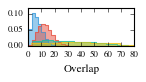

In [198]:
alpha_JSL_2, beta_JSL_2, loc_JSL_2, scale_JSL_2 = sp.stats.beta.fit(overlap_JSL_2)
alpha_FL_2, beta_FL_2, loc_FL_2, scale_FL_2 = sp.stats.beta.fit(overlap_FL_2)
alpha_AL_2, beta_AL_2, loc_AL_2, scale_AL_2 = sp.stats.beta.fit(overlap_AL_2)
alpha_NL_2, beta_NL_2, loc_NL_2, scale_NL_2 = sp.stats.beta.fit(overlap_NL_2)

overlap_fit_samples_JSL_2 = sp.stats.beta.rvs(alpha_JSL_2, beta_JSL_2, loc_JSL_2, scale_JSL_2, size=10000)
overlap_fit_samples_FL_2 = sp.stats.beta.rvs(alpha_FL_2, beta_FL_2, loc_FL_2, scale_FL_2, size=10000)
overlap_fit_samples_AL_2 = sp.stats.beta.rvs(alpha_AL_2, beta_AL_2, loc_AL_2, scale_AL_2, size=10000)
overlap_fit_samples_NL_2 = sp.stats.beta.rvs(alpha_NL_2, beta_NL_2, loc_NL_2, scale_NL_2, size=10000)

plt.figure(figsize=(3.42/2, 2.4/4), frameon=False)

# FL histogram
v_FL, b_FL = np.histogram(overlap_fit_samples_FL_2, bins=np.linspace(0, 30, 13), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=0.5)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# JSL histogram
v_JSL, b_JSL = np.histogram(overlap_fit_samples_JSL_2, bins=np.linspace(0, 30, 13), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=0.5)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# AL histogram
v_AL, b_AL = np.histogram(overlap_fit_samples_AL_2, normed=True)#, bins=np.logspace(0, np.log10(200), 15))
plt.step(b_AL, [v_AL[0]] + list(v_AL), where='pre', color="#1abc9c", lw=0.5)
b_AL_step, v_AL_step = get_x_y_steps(b_AL, [v_AL[0]] + list(v_AL), where="pre")
plt.fill_between(b_AL_step, v_AL_step, color="#1abc9c", alpha=0.5, label="AL")

# # NL histogram
v_NL, b_NL = np.histogram(overlap_fit_samples_NL_2, normed=True)
plt.step(b_NL, [v_NL[0]] + list(v_NL), where='pre', color="#f1c40f", lw=0.5)
b_NL_step, v_NL_step = get_x_y_steps(b_NL, [v_NL[0]] + list(v_NL), where="pre")
plt.fill_between(b_NL_step, v_NL_step, color="#f1c40f", alpha=0.5, label="NL")

plt.yticks([0, 0.05, 0.1])
plt.xlabel("overlap".capitalize())
plt.xlim(0, 80)

#plt.legend(frameon=False)
plt.savefig("figures/overlap_distribution_workplace_all_distr_beta_fit_wide.pdf")
plt.show()

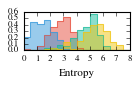

In [199]:
plt.figure(figsize=(3.42/2, 2.4/4), frameon=False)

# JSL histogram
v_JSL, b_JSL = np.histogram(entropy_JSL_2, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=0.5)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v_FL, b_FL = np.histogram(entropy_FL_2, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=0.5)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# AL histogram
v_AL, b_AL = np.histogram(entropy_AL_2, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_AL, [v_AL[0]] + list(v_AL), where='pre', color="#1abc9c", lw=0.5)
b_AL_step, v_AL_step = get_x_y_steps(b_AL, [v_AL[0]] + list(v_AL), where="pre")
plt.fill_between(b_AL_step, v_AL_step, color="#1abc9c", alpha=0.5, label="AL")

# NL histogram
v_NL, b_NL = np.histogram(entropy_NL_2, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_NL, [v_NL[0]] + list(v_NL), where='pre', color="#f1c40f", lw=0.5)
b_NL_step, v_NL_step = get_x_y_steps(b_NL, [v_NL[0]] + list(v_NL), where="pre")
plt.fill_between(b_NL_step, v_NL_step, color="#f1c40f", alpha=0.5, label="NL")

plt.xlabel("entropy".capitalize())
plt.xlim(0)

#plt.legend(frameon=False)
plt.savefig("figures/entropy_distribution_workplace_all_distr_wide.pdf")
plt.show()

/usr/local/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


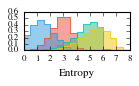

In [200]:
alpha_JSL_2, beta_JSL_2, loc_JSL_2, scale_JSL_2 = sp.stats.beta.fit(entropy_JSL_2)
alpha_FL_2, beta_FL_2, loc_FL_2, scale_FL_2 = sp.stats.beta.fit(entropy_FL_2)
alpha_AL_2, beta_AL_2, loc_AL_2, scale_AL_2 = sp.stats.beta.fit(entropy_AL_2)
alpha_NL_2, beta_NL_2, loc_NL_2, scale_NL_2 = sp.stats.beta.fit(entropy_NL_2)

entropy_fit_samples_JSL_2 = sp.stats.beta.rvs(alpha_JSL_2, beta_JSL_2, loc_JSL_2, scale_JSL_2, size=10000)
entropy_fit_samples_FL_2 = sp.stats.beta.rvs(alpha_FL_2, beta_FL_2, loc_FL_2, scale_FL_2, size=10000)
entropy_fit_samples_AL_2 = sp.stats.beta.rvs(alpha_AL_2, beta_AL_2, loc_AL_2, scale_AL_2, size=10000)
entropy_fit_samples_NL_2 = sp.stats.beta.rvs(alpha_NL_2, beta_NL_2, loc_NL_2, scale_NL_2, size=10000)

plt.figure(figsize=(3.42/2, 2.4/4), frameon=False)

# JSL histogram
v_JSL, b_JSL = np.histogram(entropy_fit_samples_JSL_2, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_JSL, [v_JSL[0]] + list(v_JSL), where='pre', color="#e74c3c", lw=0.5)
b_JSL_step, v_JSL_step = get_x_y_steps(b_JSL, [v_JSL[0]] + list(v_JSL), where="pre")
plt.fill_between(b_JSL_step, v_JSL_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v_FL, b_FL = np.histogram(entropy_fit_samples_FL_2, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_FL, [v_FL[0]] + list(v_FL), where='pre', color="#3498db", lw=0.5)
b_FL_step, v_FL_step = get_x_y_steps(b_FL, [v_FL[0]] + list(v_FL), where="pre")
plt.fill_between(b_FL_step, v_FL_step, color="#3498db", alpha=0.5, label="FL")

# AL histogram
v_AL, b_AL = np.histogram(entropy_fit_samples_AL_2, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_AL, [v_AL[0]] + list(v_AL), where='pre', color="#1abc9c", lw=0.5)
b_AL_step, v_AL_step = get_x_y_steps(b_AL, [v_AL[0]] + list(v_AL), where="pre")
plt.fill_between(b_AL_step, v_AL_step, color="#1abc9c", alpha=0.5, label="AL")

# NL histogram
v_NL, b_NL = np.histogram(entropy_fit_samples_NL_2, bins=np.linspace(0, 8, 17), normed=True)
plt.step(b_NL, [v_NL[0]] + list(v_NL), where='pre', color="#f1c40f", lw=0.5)
b_NL_step, v_NL_step = get_x_y_steps(b_NL, [v_NL[0]] + list(v_NL), where="pre")
plt.fill_between(b_NL_step, v_NL_step, color="#f1c40f", alpha=0.5, label="NL")

plt.xlabel("entropy".capitalize())
plt.xlim(0)

#plt.legend(frameon=False)
plt.savefig("figures/entropy_distribution_workplace_all_distr_beta_fit_wide.pdf")
plt.show()

### Solution NMI

In [202]:
print "JSL"

print "\temployee_team", np.mean([
        np.mean(solution_average_NMI(layer_commu_pred_JSL_2, employee_team))
        for layer_commu_pred_JSL_2 in layer_commu_pred_JSL_2_arr
    ]
)
print "\tshuffle_dict_kvs(employee_team)", np.mean([
        np.mean(solution_average_NMI(layer_commu_pred_JSL_2, shuffle_dict_kvs(employee_team)))
        for layer_commu_pred_JSL_2 in layer_commu_pred_JSL_2_arr
    ]
)

print "\nFL"

print "\temployee_team", np.mean([
        np.mean(solution_average_NMI(layer_commu_pred_FL_2, employee_team))
        for layer_commu_pred_FL_2 in layer_commu_pred_FL_2_arr
    ]
)
print "\tshuffle_dict_kvs(employee_team)", np.mean([
        np.mean(solution_average_NMI(layer_commu_pred_FL_2, shuffle_dict_kvs(employee_team)))
        for layer_commu_pred_FL_2 in layer_commu_pred_FL_2_arr
    ]
)

 JSL
	employee_team 0.742423550842
	shuffle_dict_kvs(employee_team) 0.419023628819

FL
	employee_team 0.736437154056
	shuffle_dict_kvs(employee_team) 0.432057502381


### Community entropy

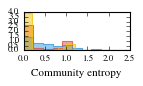

In [295]:
plt.figure(figsize=(3.42/2, 2.4/4), frameon=False)

# JSL histogram
v, b = np.histogram(commu_entropy_JSL_2, bins=np.linspace(0, 2.5, 12), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#e74c3c", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#e74c3c", alpha=0.5, label="JSL")

# FL histogram
v, b = np.histogram(commu_entropy_FL_2, bins=np.linspace(0, 2.5, 12), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#3498db", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#3498db", alpha=0.5, label="FL")

# # AL histogram
# v, b = np.histogram(commu_entropy_AL_2, bins=np.linspace(0, 2, 11), normed=True)
# plt.step(b, [v[0]] + list(v), where='pre', color="#1abc9c", lw=0.5)
# b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
# plt.fill_between(b_step, v_step, color="#1abc9c", alpha=0.5, label="AL")

# NL histogram
v, b = np.histogram(commu_entropy_NL_2, bins=np.linspace(0, 2, 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#f1c40f", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#f1c40f", alpha=0.5, label="NL")

plt.xlabel("community entropy".capitalize())
#plt.xlim(0, 2)
#plt.yscale("log")

#plt.legend(frameon=False)
plt.savefig("figures/commu_entropy_distribution_workplace_all_distr_wide.pdf")
plt.show()

### Size distribution

In [208]:
sizes_JSL_2_arr = [compute_community_size(layer_commu_pred_JSL_2, network2) for layer_commu_pred_JSL_2 in layer_commu_pred_JSL_2_arr]
sizes_FL_2_arr = [compute_community_size(layer_commu_pred_FL_2, network2) for layer_commu_pred_FL_2 in layer_commu_pred_FL_2_arr]
sizes_AL_2_arr = [compute_community_size(layer_commu_pred_AL_2, network2) for layer_commu_pred_AL_2 in layer_commu_pred_AL_2_arr]
sizes_NL_2_arr = [compute_community_size(layer_commu_pred_NL_2, network2) for layer_commu_pred_NL_2 in layer_commu_pred_NL_2_arr]

sizes_JSL_2 = ravel_two_level(sizes_JSL_2_arr)
sizes_FL_2 = ravel_two_level(sizes_FL_2_arr)
sizes_AL_2 = ravel_two_level(sizes_AL_2_arr)
sizes_NL_2 = ravel_two_level(sizes_NL_2_arr)

In [ ]:
# Doesn't fit a powerlaw!
# x = np.linspace(0, 0.2, 100)
# y_JSL = sp.stats.powerlaw.pdf(x, *sp.stats.powerlaw.fit(sizes_JSL_2))
# y_FL = sp.stats.powerlaw.pdf(x, *sp.stats.powerlaw.fit(sizes_FL_2))
# y_AL = sp.stats.powerlaw.pdf(x, *sp.stats.powerlaw.fit(sizes_AL_2))
# y_NL = sp.stats.powerlaw.pdf(x, *sp.stats.powerlaw.fit(sizes_NL_2))

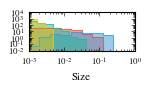

In [315]:
plt.figure(figsize=(3.42/2, 2.4/4), frameon=False)

# JSL histogram
v, b = np.histogram(sizes_JSL_2, np.logspace(np.log10(1e-3), np.log10(1), 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#e74c3c", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#e74c3c", alpha=0.5, label="JSL")
#plt.plot(x, y_JSL, color="#e74c3c", lw=2)

# FL histogram
v, b = np.histogram(sizes_FL_2, np.logspace(np.log10(1e-3), np.log10(1), 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#3498db", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#3498db", alpha=0.5, label="FL")
#plt.plot(x, y_FL, color="#3498db", lw=2)

# AL histogram
v, b = np.histogram(sizes_AL_2, np.logspace(np.log10(1e-3), np.log10(0.2), 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#1abc9c", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#1abc9c", alpha=0.5, label="AL")
#plt.plot(x, y_AL, color="#1abc9c", lw=2)

# NL histogram
v, b = np.histogram(sizes_NL_2, np.logspace(np.log10(1e-3), np.log10(0.2), 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#f1c40f", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#f1c40f", alpha=0.5, label="NL")
#plt.plot(x, y_NL, color="#f1c40f", lw=2)

plt.yscale("log")
plt.xscale("log")

plt.xlabel("size".capitalize())
plt.xlim(1e-3)

#plt.legend(frameon=False)
plt.savefig("figures/size_distribution_workplace_all_distr_wide_loglog.pdf")
plt.show()

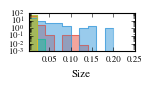

In [316]:
plt.figure(figsize=(3.42/2, 2.4/4), frameon=False)

# JSL histogram
v, b = np.histogram(sizes_JSL_2, np.linspace(0, 0.2, 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#e74c3c", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#e74c3c", alpha=0.5, label="JSL")
#plt.plot(x, y_JSL, color="#e74c3c")

# FL histogram
v, b = np.histogram(sizes_FL_2, np.linspace(0, 0.2, 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#3498db", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#3498db", alpha=0.5, label="FL")
#plt.plot(x, y_FL, color="#3498db")

# AL histogram
v, b = np.histogram(sizes_AL_2, np.linspace(0, 0.2, 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#1abc9c", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#1abc9c", alpha=0.5, label="AL")
#plt.plot(x, y_AL, color="#1abc9c")

# NL histogram
v, b = np.histogram(sizes_NL_2, np.linspace(0, 0.2, 11), normed=True)
plt.step(b, [v[0]] + list(v), where='pre', color="#f1c40f", lw=0.5)
b_step, v_step = get_x_y_steps(b, [v[0]] + list(v), where="pre")
plt.fill_between(b_step, v_step, color="#f1c40f", alpha=0.5, label="NL")
#plt.plot(x, y_NL, color="#f1c40f")

plt.yscale("log")

plt.xlabel("size".capitalize())
plt.xlim(1e-3)

#plt.legend(frameon=False)
plt.savefig("figures/size_distribution_workplace_all_distr_wide_log.pdf")
plt.show()